#### Workshop Description
Understanding the questions posed by instructors and students alike plays an important role in the development of educational technology applications. In this intermediate level workshop, you will learn to apply NLP to one piece of this real-world problem by building a model to predict the type of answer (e.g. entity, description, number, etc.) a question elicits. Specifically, you will learn to:
1. Perform preprocessing, normalization, and exploratory analysis on a question dataset,
2. Identify salient linguistic features of natural language questions, and
3. Experiment with different feature sets and models to predict the answer type.
4. Use powerful pretrained language models to create dense sentence representations and apply deep learning models to text classification.

The concepts will be taught using popular NLP and ML packages like SpaCy, Scikit Learn, and Tensorflow.

This workshop assumes familiarity with Jupyter notebooks and the basics of scientific packages like numPy and sciPy. We also assume some basic knowledge of machine learning and deep learning techniques like CNNs, LSTMs, etc. Reference materials will be provided to gain a better understanding of these techniques for interested attendees.
***

# Exploratory Data Analysis
This notebook is the 1st of 3 for the Course Hero ODSC workshop "Applications of NLP in EdTech." In this notebook, we will 

1. Load train and test data into Pandas DataFrames
2. Process question text with a pretrained SpaCy English model
3. Observe and analyze the labels and question text in an effort to inform the next steps in the ML pipeline (namely, feature extraction and text classification).


_Step 3 above involves a number of steps, some of which are listed here for reference_:
- Plotting the frequency of coarse- and fine-grained labels 
- Observing sample questions from each coarse-grained class
- Finding and removing duplicate questions
- Plotting question length (both as word count and character count)
- Observing the most common starting words, and the overall most frequent words by label.
- Looking at Named Entities and how they are distributed across the coars-grained labels.

In [2]:
###################################################
# UNCOMMENT AND RUN THIS CELL ONLY IF USING COLAB #
###################################################

# !wget -q https://raw.githubusercontent.com/coursehero/ai-odsc-workshop-2019/master/requirements.txt -O requirements.txt
# !pip install -qr requirements.txt


In [7]:
from typing import Tuple, List, Union
import matplotlib.pyplot as plt

get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

%matplotlib inline

In [8]:
plt.style.use('fivethirtyeight')

In [9]:
from os.path import exists, join
import pandas as pd
import spacy
import en_core_web_md

#
# Initialize the SpaCy model.
#
nlp = en_core_web_md.load()

### Download Data

First let's download the train and test data from Xin Li, Dan Roth, Learning Question Classifiers. COLING'02, Aug., 2002.
    <https://cogcomp.seas.upenn.edu/Data/QA/QC/">https://cogcomp.seas.upenn.edu/Data/QA/QC/>
    
We will store these data in Pandas DataFrames (and write them as .csv files) containing the following columns:
- *question*: The question text
- *processed_question*: The question as a SpaCy Doc object
- *coarse_label*: The coarse-grained label (6 classes)
- *label*: The fine-grained label

In [10]:
def format_trec_data(text):
    """
    Convert the whitespace-delimited text format of TREC data to a Pandas
    DataFrame, with the labels processed into fine- and coarse-grained
    alternatives.

    Parameters
    ----------
    text: str
        The full text of the TREC data. Each line consists of the fine-grained
        label (eg "NUM:date") followed by a space and the question text.

    Returns
    -------
    pd.DataFrame
        Pandas DataFrame with three columns: 'question', 'label', and
        'coarse_label'.

    """
    data = [line for line in text.split('\n') if line]
    labels, questions = zip(*[line.split(' ', 1) for line in data])
    coarse_labels = [label.split(':')[0] for label in labels]
    df = pd.DataFrame({"question": questions,
                       "label": labels,
                       "coarse_label": coarse_labels})
    return df

In [11]:
import pandas as pd
import requests
from os import path, mkdir

train_url = "https://cogcomp.seas.upenn.edu/Data/QA/QC/train_5500.label"
test_url = "https://cogcomp.seas.upenn.edu/Data/QA/QC/TREC_10.label"

data_dir_name = 'data'
try:
    mkdir(data_dir_name)
    print("Directory '{}' created".format(data_dir_name))
except FileExistsError:
    print("Directory '{}' already exists".format(data_dir_name))
    
data = requests.get(train_url).text
train_df = format_trec_data(data)

data = requests.get(test_url).text
test_df = format_trec_data(data)

train_df.to_csv(path.join(data_dir_name, "train.csv"), index=False)
test_df.to_csv(path.join(data_dir_name, "test.csv"), index=False)

#
# Process questions with SpaCy
#
train_df['processed_question'] = train_df.question.apply(nlp)
test_df['processed_question'] = test_df.question.apply(nlp)


Directory 'data' already exists


### Exploring Label Frequencies
Take a look at the "Coarse-Grained" (_coarse_label_) and "Fine-Grained" (_label_) labels to get an idea of how they are distributed in the training data.

Specifically, we will 
1. Group the DataFrame by coarse-grained/fine-grained label and aggregating with `.count()`.
2. Use `grouped_df.plot.barh()` to create a horizontal bar chart.

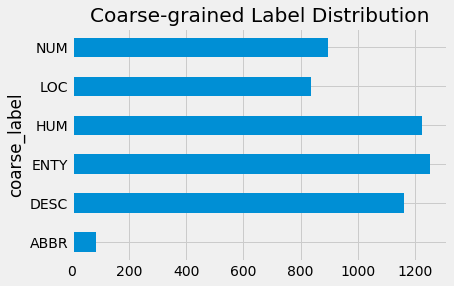

In [12]:
#
# Plot the frequencies
#
coarse_label_frequencies = train_df.groupby('coarse_label').count()['question'] 
_ = coarse_label_frequencies.plot.barh(title="Coarse-grained Label Distribution")

Generally, the coarse-grained labels are similarly-distributed, with one exception, **ABBR**. We will want to keep this in mind when we perform the modeling. Specifically, we should check that we have enough data to learn useful patterns for this underrepresented class.

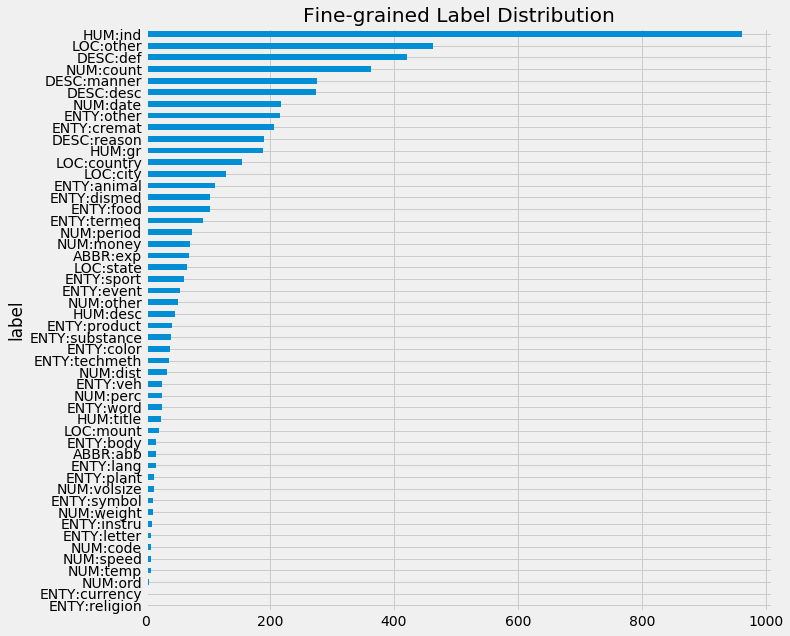

In [13]:
#
# Plot all of the fine-grained labels in a bar chart.
#
sorted_fine_grained_label_frequencies = train_df.groupby('label').count()['question'].sort_values()
_ = (sorted_fine_grained_label_frequencies
     .plot
     .barh(title="Fine-grained Label Distribution", figsize=(10,10)))

Unlike the coarse-grained label distribution, the fine-grained label distribution is quite skewed, with "HUM:ind" (human - individual) far more frequent than any other fine-grained label. We should keep this in mind if we want to tackle fine-grained question classification.

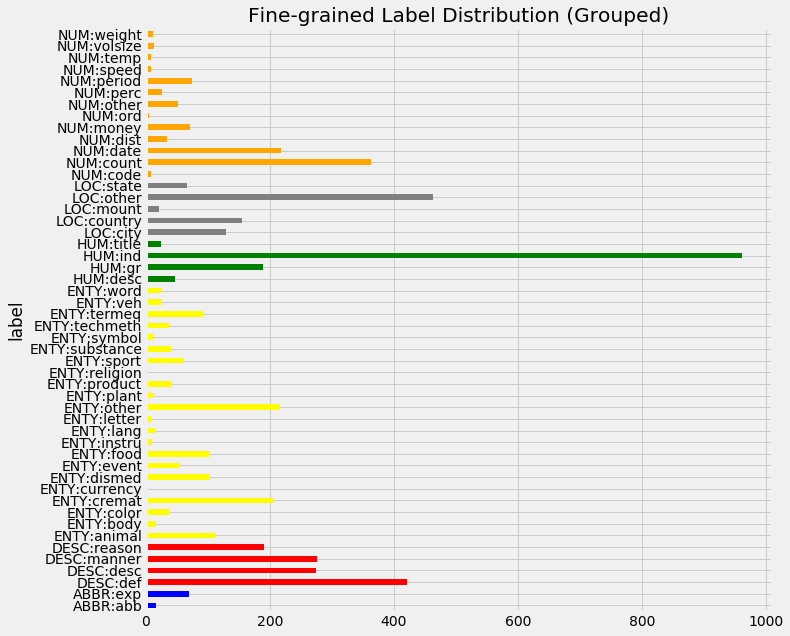

In [14]:
#
# Create a bar chart of the fine-grained labels, color-coding the coarse-grained groups.
#

colors = ['red', 'yellow', 'blue', 'green', 'orange', 'gray']

coarse_label_color_map = {label:colors[i] for i, label in enumerate(train_df.coarse_label.unique())}
fine_label_colors = []
for l in sorted(train_df.label.unique()):
    fine_label_colors.append(coarse_label_color_map[l.split(':')[0]])

    
fine_grained_label_frequencies = train_df.groupby('label').count()['question']
_ = (fine_grained_label_frequencies
     .plot
     .barh(title="Fine-grained Label Distribution (Grouped)", 
           figsize=(10,10), 
           color=fine_label_colors))

This plot helps make a bit more sense of the distribution skew in fine-grained labels. Even though HUM:ind is far more frequent than the rest, its coarse-grained class has a small number of fine-grained labels when compared to the rest of the coarse-grained labels (ENTY, for example, is spread across 22 fine-grained labels vs 3 for HUM).

### Explore the Questions!
Let's take a look at some of the question texts by sampling a few questions per coarse-grained label, using `df.sample(n)`.

In [15]:
import random

def sample_questions(coarse_label, n=10):
    question_sample = (train_df[train_df['coarse_label'] == coarse_label]
                       .sample(n).question)
    print("\n".join(question_sample))

In [16]:
#
# Human
#
sample_questions('HUM')

Which NBA players had jersey number 0 ?
Who declared : `` I think I 'll go out and milk the elk '' ?
Who was the king who was forced to agree to the Magna Carta ?
What Pope inaugurated Vatican International Radio ?
What role do fruits play in the survival of plants ?
Woodrow Wilson served as president of what university ?
What title did Shevardnadze have during the Soviet era ?
What is Larry King 's occupation ?
Name the U.S. Senate majority leader and the Speaker of the House .
What is the best distance education university or college ?


---
_Some things to notice about HUM_
- _many of the HUM questions start with 'Who'._
- _this suggests that the specific question word in the sentence may offer some indication of its label_
---

In [17]:
#
# Location
#
sample_questions('LOC')

What country will hit the year 2 first ?
What 's the nearest star to Earth ?
Where are the U.S. headquarters for Procter & Gamble ?
Where can one find information on religion and health , the brain and nutrition ?
Which large U.S. city had the highest murder rate for 1988 ?
What Texas city got its name from the Spanish for `` yellow '' ?
What two South American countries do n't border Brazil ?
What is one of the cities that the University of Minnesota is located in ?
Where are the Union Stockyards ?
What city is wiener schnitzel named for ?


---
_Some things to notice about LOC_
- _prevalence of place names_
---

In [18]:
#
# Abbreviation
#
sample_questions('ABBR')

What does INRI stand for when used on Jesus ' cross ?
What is the correct way to abbreviate cc. at the bottom of a business letter ?
What does `` B.Y.O.B. '' mean ?
What does BTU mean ?
What does ` PSI ' stand for ?
What does the `` c '' stand for in the equation E=mc2 ?
What does SIDS stand for ?
What is LMDS ?
What 's the abbreviation for trinitrotoluene ?
What does A&W of root beer fame stand for ?


---
_Some things to notice about ABBR_
- _these questions mostly tend to follow simple templates_
- _"What is [A-Z]+?", "What does __ stand for?"_
---


#### Duplicates
Check for duplicates. If there are any, let's remove them.

- To get the duplicates, group by question text and filter out groups that only have one member (those are unique questions).
- For removing duplicates, Pandas Dataframes have a really useful `.drop_duplicates()` [method!](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html)

In [19]:
#
# Count how many questions are duplicated
#
question_counts = train_df.groupby('question').count()[['label']]
question_counts.columns = ['count']
duplicate_questions = question_counts[question_counts['count'] > 1]
print("Number of duplicates:", len(duplicate_questions))
duplicate_questions.sample(5)

Number of duplicates: 63


,count
question,
How do you say 2 in Latin ?,2
What is the current ticket fare from from Cairo to Barbados ?,2
What are the chances of pregnacy if the penis does not penetrate the vagina ?,2
What is e-commerce ?,2
What is a fear of food ?,2


In [20]:
#
# Remove duplicate questions
#
print("Length before dropping duplicates:", len(train_df))
train_df = train_df.drop_duplicates("question")
print("Length after dropping duplicates:", len(train_df))

Length before dropping duplicates: 5452
Length after dropping duplicates: 5381


### Do the questions look as we expect them to?


**_How long are the questions? (number of characters and number of words)_**

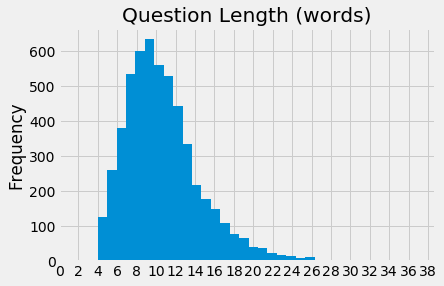

In [21]:
question_lengths_words = train_df.processed_question.apply(len)
_ = question_lengths_words.plot.hist(title="Question Length (words)", bins=35, xticks=range(0, 40, 2))


In [22]:
#
# Take a look at some of the questions with the fewest number of words.
#
sorted(list(train_df.processed_question), key=lambda q: len(q))[:10]

[Define cosmology .,
 Who shoplifts ?,
 How was Lawrence,
 Define Spumante .,
 Who killed Gandhi ?,
 What is ethology ?,
 What is titanium ?,
 What is gymnophobia ?,
 Who produces Spumante ?,
 Who discovered electricity ?]

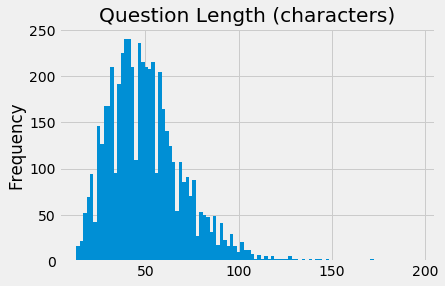

In [23]:
question_lengths_chars = train_df.question.apply(len)
_ = question_lengths_chars.plot.hist(title="Question Length (characters)", bins=100)


In [24]:
#
# Take a look at some of the questions with the fewest characters.
#
sorted(list(train_df.question), key=lambda q: len(q))[:10]

['What is BPH ?',
 'What is Plc ?',
 'What is God ?',
 'What is RCD ?',
 'What is AFS ?',
 'What is SAP ?',
 'What is DSL ?',
 'What is HTML ?',
 'What is Java ?',
 'What is DEET ?']

---

See how most of these are abbreviations? Maybe 'number of characters' will make a useful feature in our predictive model!

---

#### Are there any questions that don't have a question mark?

In [25]:
#
# How many of the questions end in question marks?
#
def ends_with_qmark(q: spacy.tokens.doc.Doc):
    return q[-1].text == '?'

print("Number of questions ending in '?': {} out of {}"
      .format(len(train_df[train_df['processed_question'].apply(ends_with_qmark)]), len(train_df)))
print("\n")
#
# And of those that don't, what do they look like?
#
print("\n".join(train_df[train_df['processed_question'].apply(lambda q: not ends_with_qmark(q))].question.sample(10)))

Number of questions ending in '?': 5254 out of 5381


Name a movie about the Sioux Indians starring Kevin Costner .
What country did the Nazis occupy for 1 , CD NNS IN NNP NNP NNP .
Name a film in which Jude Law acted .
Name Alvin 's brothers
How did U.S.A become involved in the Barbary Wars
Where do you find information about the Queensland National Competition Policy
What U.S. Congressman said : `` Keep the faith , baby '' .
Who 's the only president buried in Washington
Name the country which Honecker lived in .
Name the creator of `` The Muppets '' .


#### What about questions with more than one question mark? 

In [26]:
#
# Are there any questions that mave multiple sentences or multiple question marks?
#
def has_multiple_qmarks(q):
    return len([ch for ch in q if ch == '?']) > 1

print("Number of questions with multiple question marks:", 
      len(train_df[train_df['question'].apply(has_multiple_qmarks)]))
print("\n")
print("\n".join(train_df[train_df['question'].apply(has_multiple_qmarks)].question))

Number of questions with multiple question marks: 7


Who graced the airwaves with such pearls as `` Do ya lo-o-ove me ? Get naked , baby ! '' ?
Who was named Admiral of the Ocean Seas and Viceroy and Governor General of all the islands he might discover , and also granted 10-?? of all profits of his voyage .
Why do people in the upper peninsula of Michagin say `` eh ? '' ?
How do you exterminate bees that are in the walls of your home ? Will bee eggs remain over winter ?
How many URL extensions are there ? and what are they ?
How many `` No '' answers was the What 's My Line ? panel allowed ?
Why are there letters on the telephone ? Why are there no Q or Z ?





## What are the most common starting words?

- Extract the first word from each question (use the `processed_question` column for tokenized questions), and count their frequencies.

- Also, try counting unique word+part-of-speech tuples to see in what ways these words are used at the beginning of the questions.


What		3190
How		753
Who		556
Where		271
When		131
Which		104
Why		103
Name		88
In		66
The		18
Whose		14
On		13
CNN		5
Define		4
Whom		4
For		3
Aspartame		3
Rotary		3
Colin		3
To		2
--------------------------------------------------
What//WP		2546
How//WRB		753
What//WDT		644
Who//WP		556
Where//WRB		271
When//WRB		131
Which//WDT		104
Why//WRB		103
Name//VB		73
In//IN		66
The//DT		18
On//IN		13
Whose//WP$		13
Name//NN		10
Name//NNP		5
CNN//NNP		5
Whom//WP		4
Define//VB		3
For//IN		3
Aspartame//NN		3


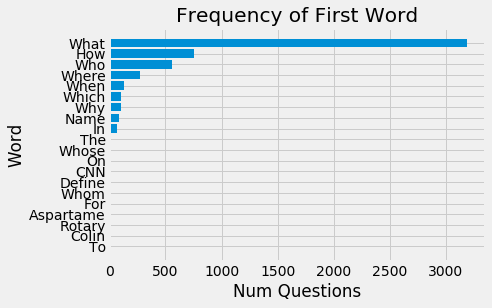

In [27]:
from collections import Counter

#
# Get the raw list of words, and word//part-of-speech.
#
starting_words = train_df.processed_question.apply(lambda q: q[0].text)
starting_words_pos = train_df.processed_question.apply(lambda q: "{}//{}".format(q[0].text, q[0].tag_))

#
# Only keep the top 20.
#
words, counts = zip(*sorted(Counter(starting_words).items(), 
                            key=lambda t: t[1], 
                            reverse=True)[:20])
words_w_pos, counts_w_pos = zip(*sorted(Counter(starting_words_pos).items(), 
                            key=lambda t: t[1], 
                            reverse=True)[:20])

#
# Print the 20 most frequent
#
print("\n".join(["{}\t\t{}".format(words[i], counts[i]) for i in range(len(words))]))
print("-" * 50)
print("\n".join(["{}\t\t{}".format(words_w_pos[i], counts_w_pos[i]) for i in range(len(words))]))


#
# Plot the starting word frequencies
#
plt.barh(words[::-1], counts[::-1])
plt.title("Frequency of First Word")
plt.ylabel("Word")
plt.xlabel("Num Questions")
plt.show()

### Word Frequency Cloud 
- Let's use the [Wordcloud](https://github.com/amueller/word_cloud) package to visualize the word frequencies for the different coarse-grained labels. 
- By default, Wordcloud removes words that are on its "stopwords" list. To avoid removing these common, often functional lexical items, specify `stopwords=[]` when calling `WordCloud()`.
- Try plotting the words with, and later without stopwords and observe the differences. What advantages there in removing the stop words as a preprocessing step? Disadvantages?

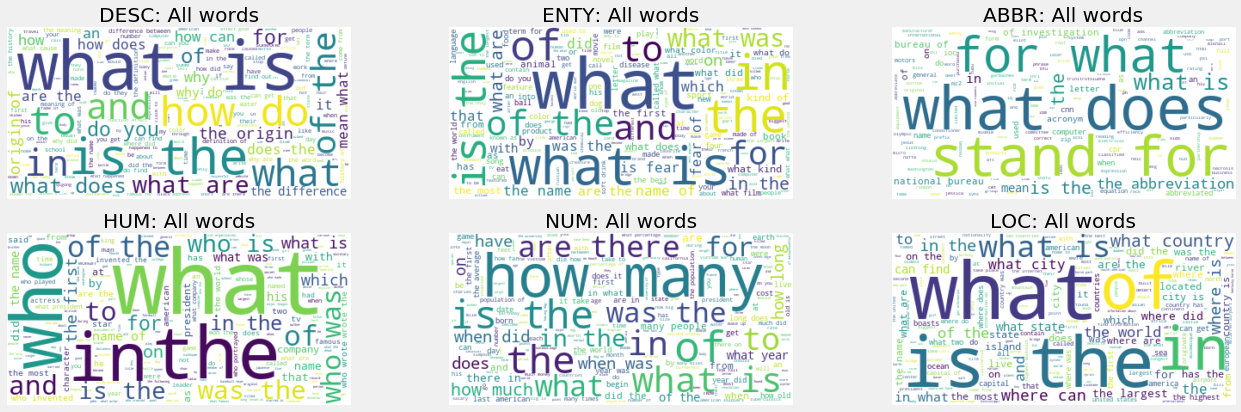

In [28]:
from wordcloud import WordCloud

plt.figure(figsize=(20, 10))
columns = 3
unique_labels = train_df.coarse_label.unique()
for i, label in enumerate(unique_labels):
    text = "\n".join(list(train_df[train_df['coarse_label'] == label].question)).lower()
    wordcloud = WordCloud(background_color='white', stopwords=[]).generate(text)
    ax = plt.subplot(len(unique_labels) / columns + 1, columns, i + 1)
    plt.title("{}: All words".format(label))
    plt.axis("off")
    plt.imshow(wordcloud, interpolation='bilinear')


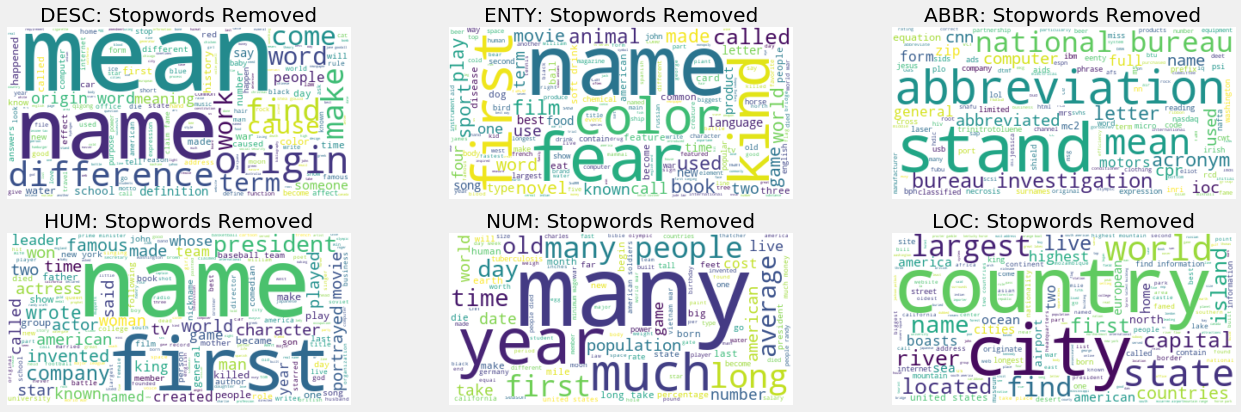

In [29]:
#
# Excluding stopwords...
#

plt.figure(figsize=(20, 10))
columns = 3

for i, label in enumerate(unique_labels):
    text = "\n".join(list(train_df[train_df['coarse_label'] == label].question)).lower()
    wordcloud = WordCloud(background_color='white').generate(text)
    ax = plt.subplot(len(unique_labels) / columns + 1, columns, i + 1)
    plt.title("{}: Stopwords Removed".format(label))
    plt.axis("off")
    plt.imshow(wordcloud, interpolation='bilinear')

### Let's explore patterns of capitalization in the data

In a lot of NLP work, the standard has always been to lowercase all text during text normalization. But, often capitalization can be quite informative. Let's see if this is the case here. </div>



Here, SpaCy provides us with tokenized text, and each token has attributes like `.is_title` is the firs letter is capitalized, and `.is_upper` if the whole word is capitalized.

In [30]:
doc = nlp("This is a TEST")
print("first token is title-cased: {}".format(doc[0].is_title))
print("last token is upper: {}".format(doc[-1].is_upper))

first token is title-cased: True
last token is upper: True


In [31]:
#
# Count the frequency of words with the first letter capitalized and show the top 50
#
title_words = [word.text for question in train_df.processed_question for word in question if word.is_title]
title_word_counts = sorted(Counter(title_words).items(), key=lambda t: t[1], reverse=True)[:50]
print("\n".join(["{}\t{}".format(w, c) for w, c in title_word_counts]))


What	3194
How	753
Who	558
Where	273
I	209
The	161
U.S.	134
When	132
Why	104
Which	104
Name	89
American	76
In	68
New	48
War	46
World	45
President	45
John	40
America	35
English	32
South	32
United	28
States	24
California	24
York	24
King	22
A	20
North	20
West	19
Day	19
French	19
Charles	19
Internet	18
Russian	18
Randy	17
Craft	17
Earth	16
British	16
Kennedy	16
London	16
San	16
National	16
Nixon	16
Germany	16
Great	15
Japanese	15
George	15
James	15
Spanish	15
England	15


In [32]:
#
# Count the frequency of words with all letters capitalized (title case) 
# and show the 50 most frequent.
#
title_words = [word.text for question in train_df.processed_question for word in question if word.is_upper]
title_word_counts = sorted(Counter(title_words).items(), key=lambda t: t[1], reverse=True)[:25]
print("\n".join(["{}\t{}".format(w, c) for w, c in title_word_counts]))

I	209
U.S.	134
TV	51
A	20
US	18
II	17
NN	15
CNN	12
F.	12
O	8
AIDS	7
NNP	7
E	7
DC	6
VHS	6
D.C.	6
USA	6
NFL	6
IBM	5
D.	5
CD	4
K	4
DT	4
J.	4
L.A.	4


### Named Entity Types 

What are the frequencies of different Named Entity types in the data? And how are they distributed across the coarse-grained labels?


We can leverage SpaCy's prebuilt English model to find the NEs:</div>
```
>>> token.ent_type_
```

In [33]:
#
# Count the frequency of 
#
title_words = [word.ent_type_ for question in train_df.processed_question for word in question if word.ent_type_]
title_word_counts = sorted(Counter(title_words).items(), key=lambda t: t[1], reverse=True)[:25]
print("\n".join(["{}\t{}".format(w, c) for w, c in title_word_counts]))

PERSON	2425
ORG	1452
GPE	1147
WORK_OF_ART	909
DATE	908
NORP	445
CARDINAL	409
LOC	394
EVENT	320
FAC	266
ORDINAL	220
QUANTITY	122
PRODUCT	94
LAW	60
TIME	40
MONEY	33
LANGUAGE	31
PERCENT	15


In [34]:
all_ne_types = []
coarse_labels = list(train_df.coarse_label.unique())
for label in coarse_labels:
    print(label)
    print("-" * 50)
    questions = train_df[train_df['coarse_label'] == label].processed_question
    ne_types = []
    for question in questions:
        ne_types += list({w.ent_type_ for w in question if w.ent_type_})
    ne_types = [word.ent_type_ for question in questions for word in question if word.ent_type_]
    freq_counts = Counter(ne_types)
    
    total = sum(freq_counts.values())
    freq_counts = {k: round(100*v/total, 0) for k, v in freq_counts.items()}
    
    ne_type_counts = sorted(freq_counts.items(), key=lambda t: t[1], reverse=True)
    all_ne_types.append(ne_type_counts)
    print("\n".join(["{}\t{}".format(w, c) for w, c in ne_type_counts]))
    print("\n\n")

DESC
--------------------------------------------------
PERSON	26.0
ORG	20.0
GPE	12.0
DATE	9.0
WORK_OF_ART	7.0
NORP	5.0
LOC	4.0
CARDINAL	4.0
LAW	3.0
EVENT	3.0
PRODUCT	2.0
MONEY	1.0
FAC	1.0
ORDINAL	1.0
LANGUAGE	1.0
TIME	1.0
QUANTITY	1.0
PERCENT	0.0



ENTY
--------------------------------------------------
PERSON	34.0
ORG	11.0
DATE	10.0
GPE	9.0
WORK_OF_ART	7.0
CARDINAL	7.0
NORP	5.0
EVENT	4.0
ORDINAL	3.0
FAC	3.0
LOC	2.0
LANGUAGE	1.0
PRODUCT	1.0
MONEY	1.0
QUANTITY	1.0
TIME	1.0
LAW	0.0
PERCENT	0.0



ABBR
--------------------------------------------------
ORG	76.0
GPE	11.0
PERSON	7.0
TIME	3.0
NORP	1.0
PRODUCT	1.0
CARDINAL	1.0



HUM
--------------------------------------------------
PERSON	31.0
WORK_OF_ART	17.0
ORG	16.0
GPE	9.0
DATE	7.0
CARDINAL	4.0
NORP	4.0
ORDINAL	3.0
EVENT	3.0
LOC	2.0
FAC	1.0
QUANTITY	1.0
PRODUCT	0.0
LAW	0.0
LANGUAGE	0.0
MONEY	0.0
TIME	0.0
PERCENT	0.0



NUM
--------------------------------------------------
DATE	21.0
PERSON	18.0
GPE	15.0
ORG	14.0
WORK_OF_ART	6.0
EVENT	

#### Final Thoughts
In this notebook, we covered a number of important steps you can take to get a better understanding of a text data set. 

There is, of course, much more that can be done to truly get a good understanding of all of the nature and nuances of the TREC question classification data.

---

Below are some references for those who would like to learn more about what was covered (and not) in this notebook:

- [Visualization in Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html)

- [EDA and NLP video](https://www.youtube.com/watch?v=VraAbgAoYSk)

- A discussion of where you probably shouldn't use word clouds <https://www.niemanlab.org/2011/10/word-clouds-considered-harmful/>